In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### 1. input :  ligand poses: sdf files ; protein: pdb file
### 2. change the dir of the input

In [2]:
dir_ = "/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case/toy_data/"

### 3. extracing the protein pocket

In [3]:
# ====== extract the pocket:  define function ======
from scipy.spatial import distance_matrix
from Bio.PDB import *
from Bio.PDB.PDBIO import Select
import os
import numpy as np
import pandas as pd
from rdkit import Chem


def extract(ligand, pdb):
    parser = PDBParser()
    if not os.path.exists(pdb) :
        print("The path of PDB is not available.")
        return None

    structure = parser.get_structure("protein", pdb)

    lp = []
    for l in ligand:
        lp.append(l.GetConformer().GetPositions())
    ligand_positions=np.concatenate(lp)

    class ResidueSelect(Select):
        def accept_residue(self, residue):
            residue_positions = np.array([np.array(list(atom.get_vector())) \
                for atom in residue.get_atoms() if "H" not in atom.get_id()])
            if len(residue_positions.shape) < 2:
                print(residue)
                return 0
            min_dis = np.min(distance_matrix(residue_positions, ligand_positions))
            if min_dis < 8.0:
                return 1
            else:
                return 0
    io = PDBIO()
    io.set_structure(structure)
    fn =  pdb.replace('protein.pdb', 'pocket.pdb')
    io.save(fn, ResidueSelect())  


def pocket_extract(sdf_files, protein_file):

    ligands = []
    for a in sdf_files:
        mol = Chem.MolFromMolFile(a)
        if mol is not None:
            ligands.append(mol)
        else:
            print(f"{a} connot be read by rdkit!")

    extract(ligands,protein_file)


    print("The pocket has been extracted successfully.")

In [4]:
# run
d = dir_
sdfs = [d+i for i in os.listdir(d) if i.endswith('.sdf')][1:]
for sdf in sdfs:
    pocket_extract([sdf], d + '/protein.pdb')

The pocket has been extracted successfully.
The pocket has been extracted successfully.
The pocket has been extracted successfully.
The pocket has been extracted successfully.
The pocket has been extracted successfully.


### 4. sdf files to pickle files (graph generation)

In [5]:
# ===== graph generation ======
from rdkit.Chem.rdchem import BondType as BT
import pickle
from rdkit import Chem
from rdkit.Chem import BRICS
import numpy as np
import pandas as pd
import torch
import os
import warnings
import multiprocessing
import dgl
from Bio.PDB.PDBParser import PDBParser

def setup_cpu(cpu_num):
    os.environ['OMP_NUM_THREADS'] = str(cpu_num)
    os.environ['OPENBLAS_NUM_THREADS'] = str(cpu_num)
    os.environ['MKL_NUM_THREADS'] = str(cpu_num)
    os.environ['VECLIB_MAXIMUM_THREADS'] = str(cpu_num)
    os.environ['NUMEXPR_NUM_THREADS'] = str(cpu_num)
    # torch.set_num_threads(cpu_num)

warnings.filterwarnings('ignore')

allowable_features = {
    # 'possible_atomic_num_list': list(range(1, 119)) + ['misc'],
    'possible_chirality_list': ['CHI_UNSPECIFIED',
                                'CHI_TETRAHEDRAL_CW',
                                'CHI_TETRAHEDRAL_CCW',
                                'CHI_OTHER'],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_numring_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_implicit_valence_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list': ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring3_list': [False, True],
    'possible_is_in_ring4_list': [False, True],
    'possible_is_in_ring5_list': [False, True],
    'possible_is_in_ring6_list': [False, True],
    'possible_is_in_ring7_list': [False, True],
    'possible_is_in_ring8_list': [False, True]
    }

def safe_index(l, e):
    """ Return index of element e in list l. If e is not present, return the last index """
    try:
        return l.index(e)
    except:
        return len(l) - 1

# residue Information , not used in PBCNet2.0!
# ====== for pockt group =======
one_to_three = {"A" : "ALA",
              "C" : "CYS",
              "D" : "ASP",
              "E" : "GLU",
              "F" : "PHE",
              "G" : "GLY",
              "H" : "HIS",
              "I" : "ILE",
              "K" : "LYS",
              "L" : "LEU",
              "M" : "MET",
              "N" : "ASN",
              "P" : "PRO",
              "Q" : "GLN",
              "R" : "ARG",
              "S" : "SER",
              "T" : "THR",
              "V" : "VAL",
              "W" : "TRP",
              "Y" : "TYR",
              "B" : "ASX",
              "Z" : "GLX",
              "X" : "UNK",
              "*" : " * "}

three_to_one = {}
for _key, _value in one_to_three.items():
    three_to_one[_value] = _key
three_to_one["SEC"] = "C"
three_to_one["MSE"] = "M"

pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                 'X']
pro_res_aliphatic_table = ['A', 'I', 'L', 'M', 'V']
pro_res_aromatic_table = ['F', 'W', 'Y']
pro_res_polar_neutral_table = ['C', 'N', 'Q', 'S', 'T']
pro_res_acidic_charged_table = ['D', 'E']
pro_res_basic_charged_table = ['H', 'K', 'R']

def prop(residue):
    res_property1 = [1 if residue in pro_res_aliphatic_table else 0, 1 if residue in pro_res_aromatic_table else 0,
                        1 if residue in pro_res_polar_neutral_table else 0,
                        1 if residue in pro_res_acidic_charged_table else 0,
                        1 if residue in pro_res_basic_charged_table else 0, 1]
    return res_property1

def res_pocket(p):

    parser = PDBParser(PERMISSIVE=1)
    s = parser.get_structure('a', p)
   
    atom2res_idx = []
    res_name = []
    count = -1
    for model in s:
        for chain in model:
            for residue in chain:
                count += 1
                name = residue.get_resname()
                for atom in residue:
                    if atom.get_fullname() [0] != 'H' and atom.get_fullname()[1] != 'H':
                        atom2res_idx.append(count)
                        res_name.append(name)

    res3 = [three_to_one[i] if i in three_to_one.keys() else 'X' for i in res_name]

    res_type = [pro_res_table.index(i) for i in res3]  
    res_prop  = [prop(i) for i in res3] 
    assert len(atom2res_idx) == len(res_type) == len(res_prop)
    return atom2res_idx, res_type, res_prop


def lig_atom_featurizer(mol):
    ringinfo = mol.GetRingInfo()
    atom_features_list = []
    for idx, atom in enumerate(mol.GetAtoms()):
        atom_features_list.append([
            safe_index(allowable_features['possible_chirality_list'], str(atom.GetChiralTag())),
            safe_index(allowable_features['possible_degree_list'], atom.GetTotalDegree()),
            safe_index(allowable_features['possible_formal_charge_list'], atom.GetFormalCharge()),
            safe_index(allowable_features['possible_numH_list'], atom.GetTotalNumHs()),
            safe_index(allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
            allowable_features['possible_is_aromatic_list'].index(atom.GetIsAromatic()),
            safe_index(allowable_features['possible_implicit_valence_list'], atom.GetImplicitValence()),
            safe_index(allowable_features['possible_number_radical_e_list'], atom.GetNumRadicalElectrons()),
            safe_index(allowable_features['possible_numring_list'], ringinfo.NumAtomRings(idx)),
            # allowable_features['possible_is_in_ring3_list'].index(ringinfo.IsAtomInRingOfSize(idx, 3)),
            # allowable_features['possible_is_in_ring4_list'].index(ringinfo.IsAtomInRingOfSize(idx, 4)),
            # allowable_features['possible_is_in_ring5_list'].index(ringinfo.IsAtomInRingOfSize(idx, 5)),
            # allowable_features['possible_is_in_ring6_list'].index(ringinfo.IsAtomInRingOfSize(idx, 6)),
            # allowable_features['possible_is_in_ring7_list'].index(ringinfo.IsAtomInRingOfSize(idx, 7)),
            # allowable_features['possible_is_in_ring8_list'].index(ringinfo.IsAtomInRingOfSize(idx, 8)),
        ])

    return atom_features_list


def group_complex(ligand, pocket_dir):
    brics_index = brics_decomp(ligand)
    group_index = [0 for _ in range(len(ligand.GetAtoms()))]
    group_type = [0 for _ in range(len(ligand.GetAtoms()))]   # 0
    group_prop = [[0,0,0,0,0,0] for _ in range(len(ligand.GetAtoms()))] # 0

    if type(brics_index) == type(tuple(('a', 'b', 'c'))):
        brics_index = brics_index[0]

    for i, idx in enumerate(brics_index):
        for idx_ in idx:
            group_index[idx_] = i

    atom2res_idx, res_type, res_prop = res_pocket(pocket_dir)

    atom2res_idx = [i+len(brics_index) for i in atom2res_idx] 
    res_type = [i+1 for i in res_type] 

    group_index.extend(atom2res_idx)
    group_type.extend(res_type)
    group_prop.extend(res_prop)

    return torch.tensor(group_index,dtype=torch.float32), torch.tensor(group_type,dtype=torch.float32), torch.tensor(group_prop, dtype=torch.float32)


def atom_type(ligand,pocket):
    # ====== 获得原子类型 ======
    l_atom = np.array([i.GetAtomicNum() for i in ligand.GetAtoms()])
    lig_atom = [1 for _ in l_atom]
    p_atom = np.array([i.GetAtomicNum() for i in pocket.GetAtoms()])
    pock_atom = [0 for _ in p_atom]
    complex_atom = torch.tensor(np.concatenate([l_atom, p_atom]))
    type_for_mask = torch.tensor(np.concatenate([lig_atom, pock_atom]))
    z = complex_atom
    return z, type_for_mask


bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3} # 4:分子内部边; 5:蛋白内部边; 6:蛋白-配体边

def bond_featurizer(ligand, pocket, index):
    bond_type = []
    num_atoms = len(ligand.GetAtoms())
    for a1, a2 in zip(index[0], index[1]):
        if a1 < num_atoms and a2 < num_atoms:   # in ligand
            bond = ligand.GetBondBetweenAtoms(a1, a2)
            if bond is None:
                bond_type.append(4)   # distance bond
            else:
                bond_type.append(bonds[bond.GetBondType()])
        elif a1 >= num_atoms and a2 >= num_atoms: # in pock
            a1 = a1 - num_atoms
            a2 = a2 - num_atoms
            bond = pocket.GetBondBetweenAtoms(a1, a2)
            if bond is None:
                bond_type.append(4)   # distance bond
            else:
                bond_type.append(bonds[bond.GetBondType()])
        else:
            bond_type.append(4)
    return torch.tensor(bond_type, dtype=torch.float32)
    

# ===== mol split =====
# R-group Information , not used in PBCNet2.0!
def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques


def Graph_Information(ligand_file, pocket_file):

    ligand = Chem.MolFromMolFile(ligand_file)
    ligand = Chem.RemoveAllHs(ligand)
    pocket = Chem.MolFromPDBFile(pocket_file)
    pocket = Chem.RemoveAllHs(pocket)


    graph_data = {
                ('atom', 'int', 'atom'): ([], []),
                ('atom', 'ind', 'atom'): ([], [])      # 'ind' bond is not used in PBCNet2.0

                }
    G = dgl.heterograph(graph_data)

    # ====== atom type =======
    x, type_for_mask = atom_type(ligand, pocket)
    G.add_nodes(x.shape[0])
    
    # ====== chemical information =======
    lig_atom_feature = lig_atom_featurizer(ligand)
    pock_atom_feature = lig_atom_featurizer(pocket)
    atom_scalar = torch.tensor(np.concatenate([lig_atom_feature, pock_atom_feature]), dtype=torch.float32)

    # ===== group infor =====
    index, g_type, g_prop = group_complex(ligand, pocket_file)

    # ====== coor ======
    coor_lig = ligand.GetConformer().GetPositions()
    coor_pock = pocket.GetConformer().GetPositions()
    pos = np.concatenate([coor_lig, coor_pock])
    pos = torch.tensor(pos, dtype=torch.float32)
    G.nodes['atom'].data['pos'] = pos
    
    # ====== type1: in mol (all: dist and or) ======  
    for i in range(len(coor_lig)):
        for j in range(i + 1, len(coor_lig)):
            dist = np.linalg.norm(coor_lig[i] - coor_lig[j])
            if dist <= 5 and dist > 0:
                G.add_edges(i, j, etype='int')
                G.add_edges(j, i, etype='int')
                continue

    # ====== type2: in pock (co) ======  
    for bond in pocket.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        G.add_edges(start_atom + len(coor_lig), end_atom + len(coor_lig), etype='int')
        G.add_edges(end_atom + len(coor_lig), start_atom + len(coor_lig), etype='int')
        continue


    # ====== type3: in ligand and pock  ======  
    for i in range(len(coor_lig)):
        for j in range(len(coor_pock)):
            dist = np.linalg.norm(coor_lig[i] - coor_pock[j])
            if dist <= 5 and dist > 0:
                G.add_edges(i, len(coor_lig) + j, etype='int')
                G.add_edges(len(coor_lig) + j, i, etype='int')
                continue
    
    # ====== type4: in pock (distance) ======  
    connected_protein_atoms = set(j for i in range(len(coor_lig)) for j in G.successors(i,etype='int') if j >= len(coor_lig))
    # print(connected_protein_atoms)
    for i in connected_protein_atoms:
        for j in range(len(coor_pock)):
            dist = np.linalg.norm(coor_pock[i - len(coor_lig)] - coor_pock[j])
            if  (dist <= 3) and (dist > 0) and  (G.has_edges_between(i, len(coor_lig) + j, etype='int').item() is False):
                G.add_edges(i, len(coor_lig) + j, etype='int')
                G.add_edges(len(coor_lig) + j, i, etype='int')
                continue

    edge_index_int = [G.edges(etype='int')[0].detach().numpy().tolist(), G.edges(etype='int')[1].detach().numpy().tolist()]
    edge_index_ind = [G.edges(etype='ind')[0].detach().numpy().tolist(), G.edges(etype='ind')[1].detach().numpy().tolist()]

    bond_type_int = bond_featurizer(ligand, pocket, edge_index_int)
    bond_type_ind = bond_featurizer(ligand, pocket, edge_index_ind)
    
    #index, g_type, g_prop
    G.nodes['atom'].data['res_idx'] = index
    G.nodes['atom'].data['res_type'] = g_type
    G.nodes['atom'].data['res_prop'] = g_prop

    G.nodes['atom'].data['x'] = x
    G.nodes['atom'].data['pos'] = pos
    G.nodes['atom'].data['type'] =type_for_mask
    G.nodes['atom'].data['atom_scalar'] = atom_scalar
    G.edges['ind'].data['bond_scalar'] = bond_type_ind
    G.edges['int'].data['bond_scalar'] = bond_type_int
    return G

def graph_save(ligand_file, pock_file, pickle_save):
    
    if not (os.path.exists(ligand_file) and os.path.exists(pock_file)):
        return None

    data = Graph_Information(ligand_file, pock_file)
    pickle_save = open(pickle_save, 'wb')
    pickle.dump(data, pickle_save)
    pickle_save.close()

In [6]:
"/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case/toy_data/pocket.pdb"

'/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case/toy_data/pocket.pdb'

In [7]:
# run

data_list = []
d = dir_
sdfs = [d+i for i in os.listdir(d) if i.endswith('.sdf')]
for sdf in sdfs:
    data_list.append([sdf, f'{dir_}/pocket.pdb', sdf.replace('.sdf', '.pkl')])

for ligand_file, pock_file, pickle_save in data_list:
    graph_save(ligand_file, pock_file, pickle_save)

### 5.  The final input form of PBCNet2 is a csv file. So, we should convert our data to a csv file.
###     The process is matched to the user's needs and the user can change it to suit their needs. The example shown here pairs all ligands.

In [8]:
# ===== input file generation =======

from rdkit import Chem
from rdkit import DataStructs

def input_G(pickles, lab):

    N1 = []
    N2 = []
    L1 = []
    L2 = []
    L = []
    D1 = []
    D2 = []
    data_list = []
    for i, pkl1 in enumerate(pickles):
        l1 = lab[i]
        if i == len(pickles) -1:
            break
        for j, pkl2 in enumerate(pickles):
            l2 = lab[j]

            N1.append(pkl1.split('/')[-1])
            D1.append(pkl1)
            N2.append(pkl2.split('/')[-1])
            D2.append(pkl2)
            L1.append(l1)
            L2.append(l2)
            L.append(l1-l2)

        data_list.append(pd.DataFrame({
                    'lig1' : N1,
                    'lig2' : N2,
                    'Label' : L,
                    'Label1' : L,
                    'Label2' : L,
                    'dir_1':D1,
                    'dir_2':D2
                }))

    pd.concat(data_list).to_csv(dir_ + '/predict.csv',index = 0)


In [9]:
# run
names = [dir_+'/'+i for i in os.listdir(dir_) if i.endswith('.pkl')]
ic50 = [7.47,8.52,8.3,7.77,7.6,8.1]  # their pic50
input_G(names,ic50)

In [10]:
pd.read_csv(dir_ + '/predict.csv')

,lig1,lig2,Label,Label1,Label2,dir_1,dir_2
0,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078691.pkl,0.00,0.00,0.00,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
1,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1082248.pkl,-1.05,-1.05,-1.05,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
2,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1077227.pkl,-0.83,-0.83,-0.83,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
3,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078774.pkl,-0.30,-0.30,-0.30,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
4,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078998.pkl,-0.13,-0.13,-0.13,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
...,...,...,...,...,...,...,...
85,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1082248.pkl,-0.92,-0.92,-0.92,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
86,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1077227.pkl,-0.70,-0.70,-0.70,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
87,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1078774.pkl,-0.17,-0.17,-0.17,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...
88,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1078998.pkl,0.00,0.00,0.00,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...


### 6. Prediction

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import dgl
import sys

# here, the path should be changed accordingly
sys.path.append("/home/user-home/yujie/0_PBCNetv2/0_PBCNET/model_code/")
code_path = '/home/user-home/yujie/0_PBCNetv2/0_PBCNET/'

from Dataloader.dataloader import LeadOptDataset, collate_fn
from utilis.utilis import  pkl_load
from predict.predict import predict

/home/user-home/yujie/0_PBCNetv2/0_PBCNET


In [12]:
def test(logger_writer,model,device,code_path,batch_size):
    rmse_gs = []
    model.to(device)
    df_file = pd.read_csv(dir_ + "/predict.csv")

    test_dataset = LeadOptDataset(dir_ + "/predict.csv")
    test_dataloader = DataLoader(test_dataset,
                                 collate_fn=collate_fn,
                                 batch_size=batch_size,
                                 drop_last=False,
                                 shuffle=False,
                                 pin_memory=False)
    mae,rmse,mae_g,rmse_g,valid_prediction,valid_prediction_G,valid_labels,ref_1_label,val_2_label= predict(model, test_dataloader, device)
    
    return valid_prediction


model = torch.load(f"{code_path}/PBCNet2.pth",map_location=torch.device('cpu'),weights_only=False)

pre = test(None,model,'cpu',code_path,8)

import pandas as pd
df_file = pd.read_csv(dir_ + "/predict.csv")
df_file['pre'] = pre
df_file.to_csv(dir_ + "/predict.csv",index=0)

In [13]:
df_file

,lig1,lig2,Label,Label1,Label2,dir_1,dir_2,pre
0,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078691.pkl,0.00,0.00,0.00,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-0.079605
1,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1082248.pkl,-1.05,-1.05,-1.05,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-0.645374
2,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1077227.pkl,-0.83,-0.83,-0.83,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-0.405169
3,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078774.pkl,-0.30,-0.30,-0.30,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,0.076197
4,lig_eg5_CHEMBL1078691.pkl,lig_eg5_CHEMBL1078998.pkl,-0.13,-0.13,-0.13,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,1.428247
...,...,...,...,...,...,...,...,...
85,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1082248.pkl,-0.92,-0.92,-0.92,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-1.492982
86,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1077227.pkl,-0.70,-0.70,-0.70,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-1.584552
87,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1078774.pkl,-0.17,-0.17,-0.17,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-0.988493
88,lig_eg5_CHEMBL1078998.pkl,lig_eg5_CHEMBL1078998.pkl,0.00,0.00,0.00,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,/home/user-home/yujie/0_PBCNetv2/0_PBCNET/case...,-0.079651


### 6.visualization

In [14]:
import scipy.stats as stats
import pickle
from sklearn.metrics import  mean_squared_error
def S(X, Y):
    return stats.spearmanr(X, Y)[0]
def R(X, Y):
    return stats.pearsonr(X, Y)[0]
def RMSE(X,Y):
    return mean_squared_error(X,Y) ** 0.5
    
print(S(df_file['Label'],df_file['pre']))
print(R(df_file['Label'],df_file['pre']))
print(RMSE(df_file['Label'],df_file['pre']))

0.7199420340005028
0.6920313993051723
0.5580339010864525


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ================================== delta值========================================
def plt_scatter(x,y):
    
    fig, axs = plt.subplots(1,1,figsize=(13,10))
    fig.dpi=600

    axs.scatter( x,y, alpha = 1,s=100,c=['#138787'],zorder=2)


    parameter = np.polyfit(x, y, 1)
    y2 = parameter[0] * np.array(x) + parameter[1]
    print(parameter[0])

    axs.plot(x,y2,ls="-", linewidth=2,alpha = 0.6,c='k')
    axs.tick_params(labelsize=12)

    # new_legend_content = ['Spearman: 0.77\nPearson: 0.36']
    # axs.legend(new_legend_content, loc='upper left',fontsize=20)

    axs.set_ylabel("Pred. pIC50", fontsize=40)
    axs.set_xlabel("Exp. pIC50", fontsize=40)
    axs.set_title('Toy data',fontsize=40)

    plt.tight_layout()
    plt.style.use("ggplot")
    plt.show()

0.8392150822057985


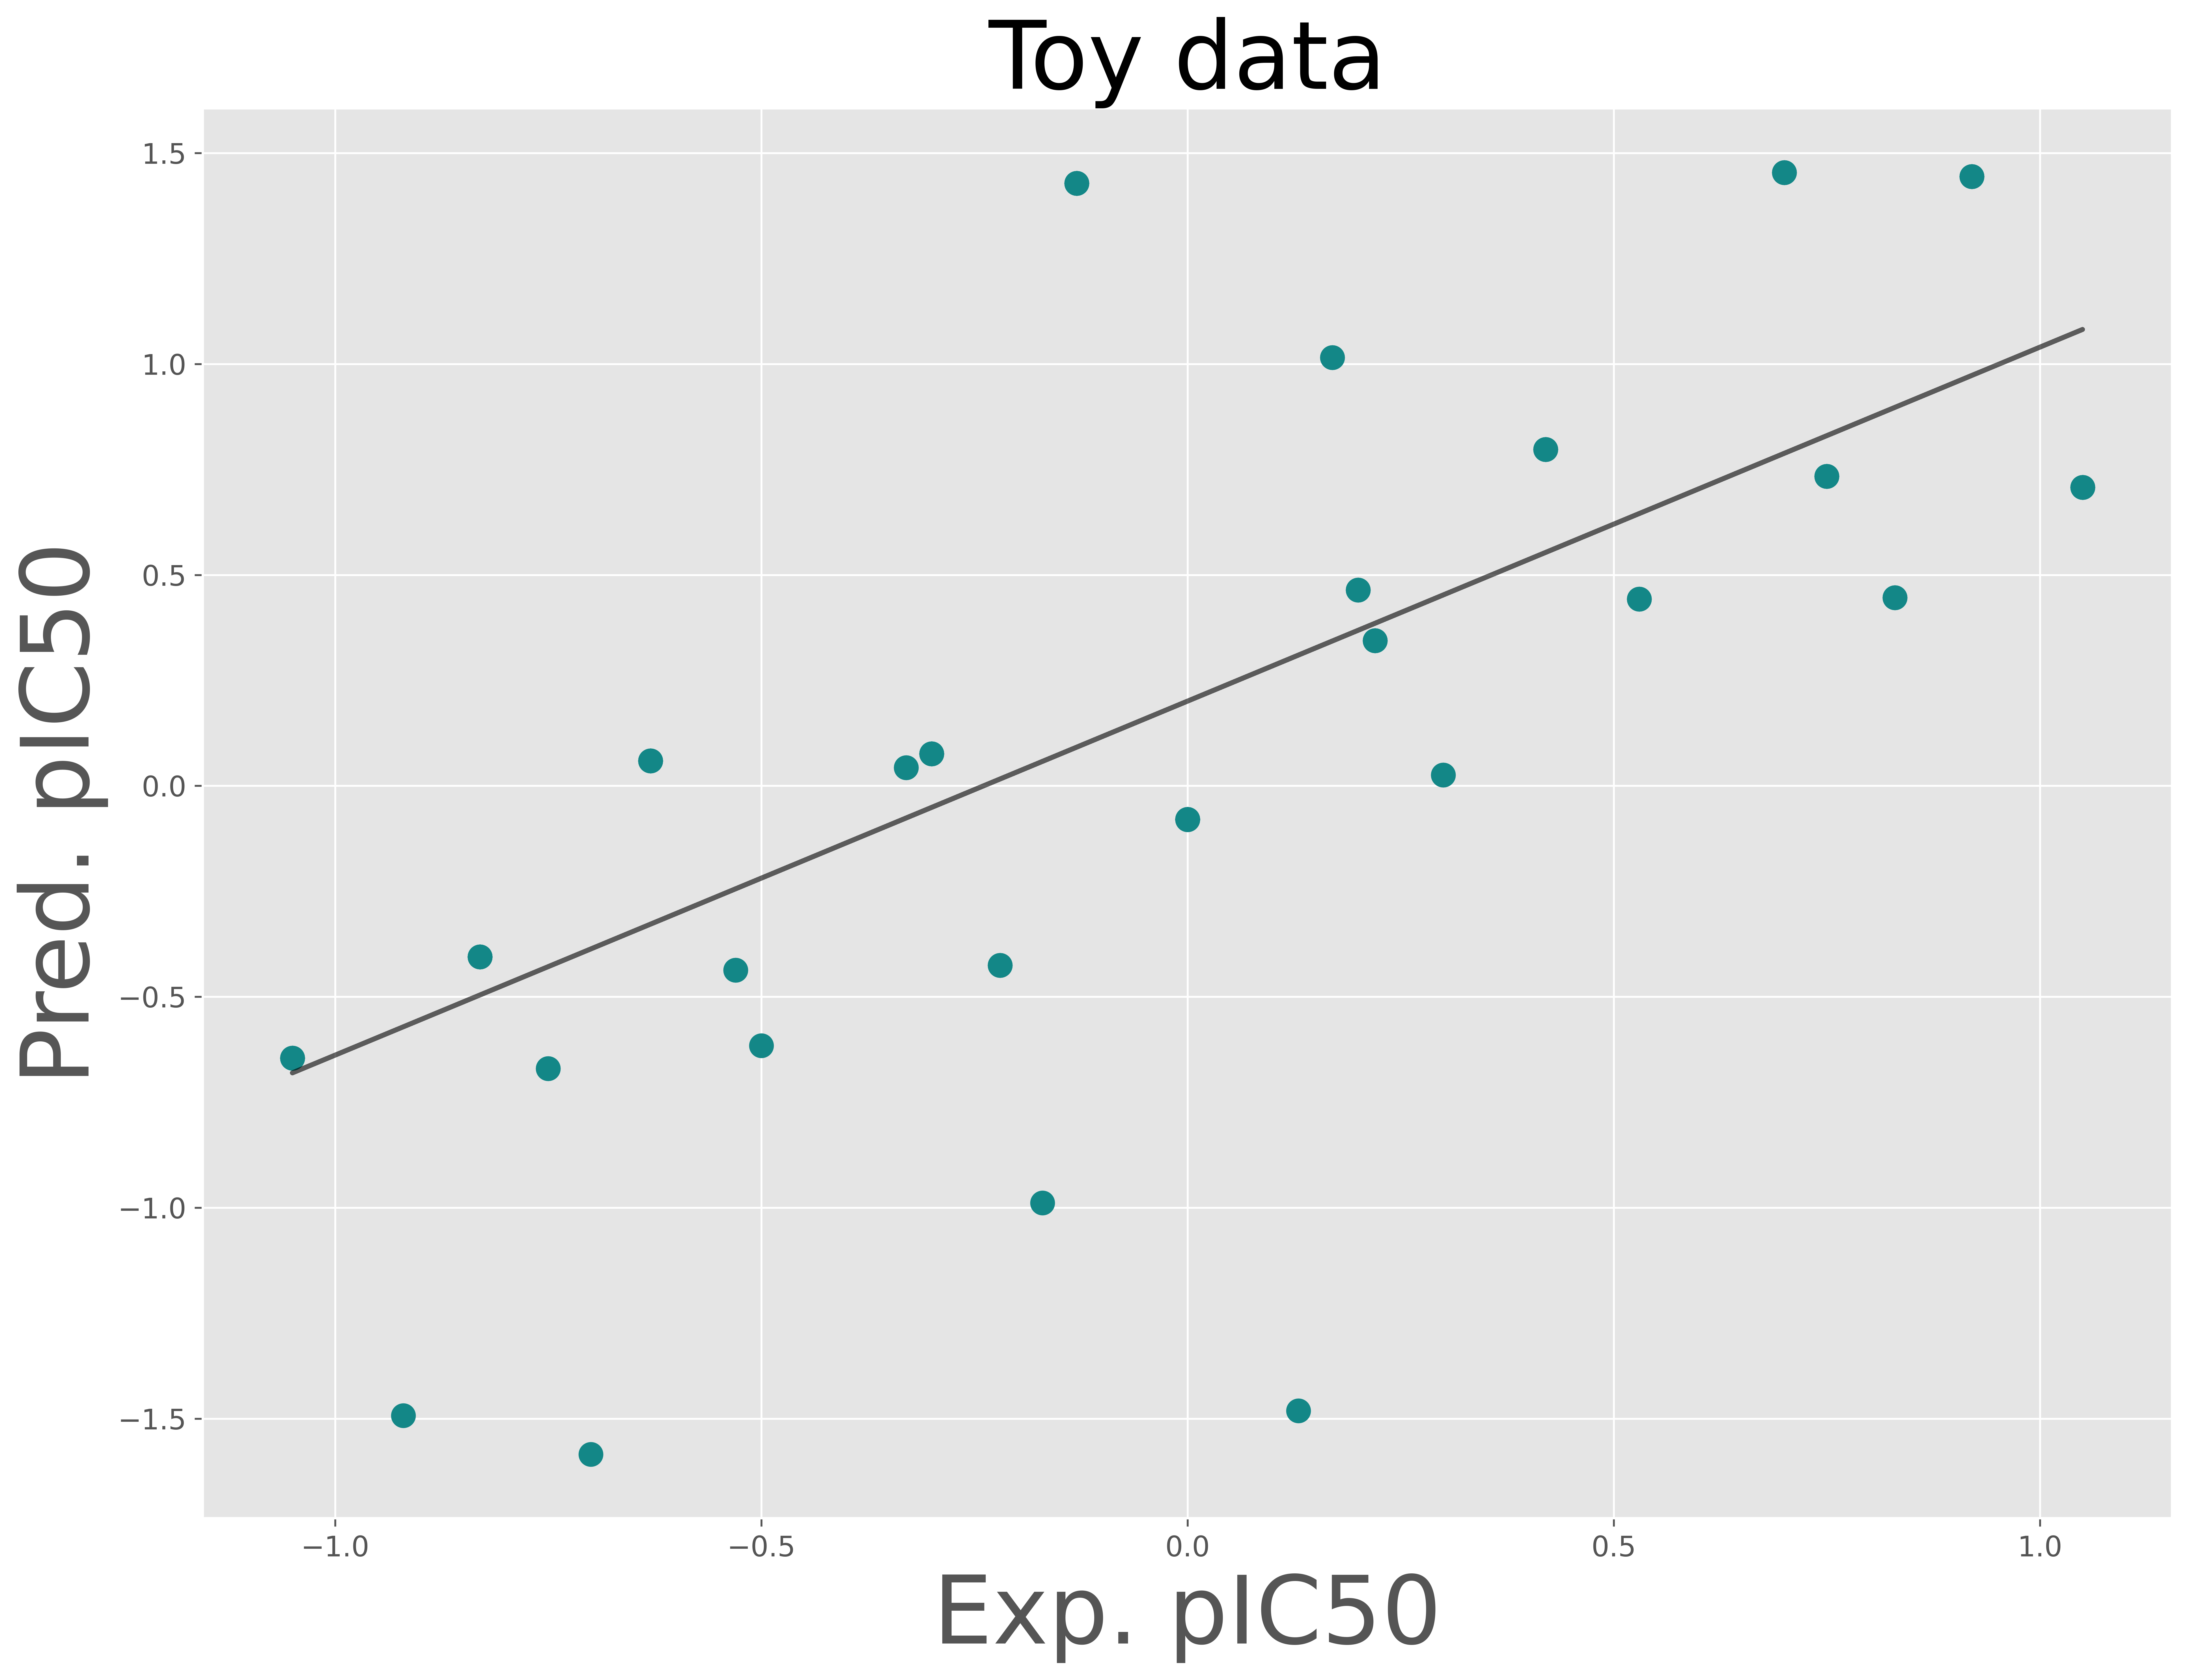

In [18]:
plt_scatter(df_file['Label'],df_file['pre'])